# [Paper](https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf)

In [55]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import csv
%matplotlib inline

In [56]:
names = set()
with open("names.csv", "r") as csvfile:
     csvreader = csv.reader(csvfile)
     for row in csvreader:
        name = row[0].split(";")[1]
        if name[0] != "_":
            names.add(name)

In [57]:
alphabet = set()
for name in names:
    for l in name:
        alphabet.add(l)
N = len(alphabet)+1
stoi = {i:k+1 for k,i in enumerate(alphabet)}
stoi['.'] = 0
itos = {k:i for i,k in stoi.items()}

In [58]:
block_size = 3
def build_dataset(names):
    X, Y = [], []
    for name in names:
        context = [0]*block_size
        for ch in name + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]
    return torch.tensor(X),torch.tensor(Y)

names = list(names)
import random
random.shuffle(names)
Xtrain, Ytrain = build_dataset(names[:int(0.9*len(names))])
Xtest, Ytest = build_dataset(names[int(0.9*len(names)):])

In [59]:
L0 = torch.randn((52, 20))
W1 = torch.randn((60, 300)) * (5/3)/(60)**0.5
W2 = torch.randn((300, 52))* 0.01
B2 = torch.randn(52)*0
bngain = torch.ones((1, 300))
bnbias = torch.zeros((1, 300))
parameters = [L0, W1, W2, B2, bngain, bnbias]
for p in parameters:
    p.requires_grad = True

In [60]:
lossi = []
stepi = []

2.3072173595428467
2.6345584392547607


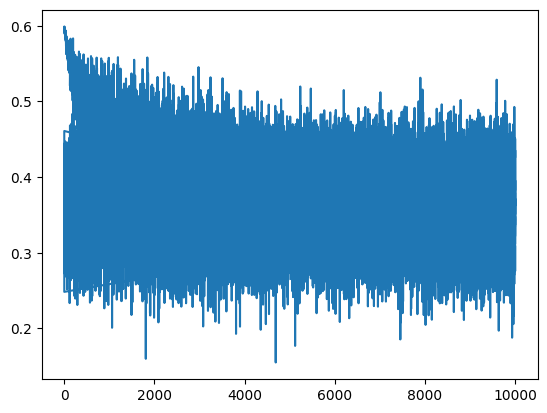

In [68]:
n_max = 100_00

for i in range(n_max):
    ix = torch.randint(0, Xtrain.shape[0], (32,))
    hpreact = L0[Xtrain[ix]].view(-1,60) @ W1 
    normalized_hpreact = (hpreact - hpreact.mean(0, keepdim=True))/hpreact.std(0, keepdim=True)
    hpreact = bngain * normalized_hpreact - bnbias
    h = (hpreact).tanh()
    logits = h @ W2 + B2
    loss = F.cross_entropy(logits, Ytrain[ix])
    for p in parameters:
        p.grad = None
    loss.backward()
    lossi.append(loss.log10().item())
    stepi.append(i)
    for p in parameters:
        p.data += -0.01*p.grad

print(loss.item()) 
print(F.cross_entropy((L0[Xtest].view(-1,60) @ W1 + B1).tanh() @ W2 + B2, Ytest).item())
plt.plot(stepi, lossi)

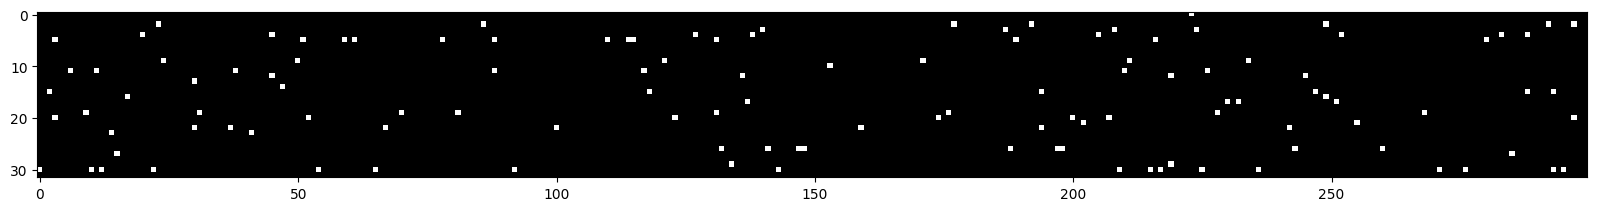

In [84]:
plt.figure(figsize=(20,10))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest')